In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix, roc_curve, confusion_matrix, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

from pipelines import nested_cross_validate_score, pipeline_Donker
from transform import combine_tsv_files
from utils import double_cross_validate, get_sub_pipeline

In [2]:
# Difference genomic variable.
X, y = combine_tsv_files(
    "output/all__gene__up_or_down__No. Mutant Molecules per mL.tsv",
    "output/all__gene__up_or_down__CNV Score.tsv",
)

y_resp = y['response_grouped'].map({
    'non responder (sd+pd)': 'non responder (sd+pd+ne)', 
    'non evaluable (ne)': 'non responder (sd+pd+ne)',
    'responder (pr+cr)': 'responder (pr+cr)',
})

In [3]:
y_OS = y['OS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['OS_months'] < 12.0]['Censor_OS'] == 1.0)

y_PFS = y['PFS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['PFS_months'] < 12.0]['Censor_progression'] == 'progression of disease')

In [4]:
# p = pipeline_Donker(CategoricalNB())
p = pipeline_Donker(ComplementNB())

In [5]:
@double_cross_validate(5, 5)
def metrics_binary_class(clf, X, y, positive_class):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    class_index = list(clf.classes_).index(positive_class)
    y_prob = clf.predict_proba(X)[:, class_index]
    y_pred = clf.predict(X)
    fpr, tpr, _ = roc_curve(y, y_prob, pos_label=positive_class)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    metrics.update(
        {
            f"{positive_class}__tprs": interp_tpr,
            f"{positive_class}__fprs": mean_fpr,
            f"{positive_class}__roc_auc": roc_auc_score(y, y_prob),
            f"{positive_class}__accuracy": accuracy_score(y, y_pred),
            f"{positive_class}__confusion_matrix": confusion_matrix(
                y, y_pred, normalize="true"
            ),
        }
    )
    print(positive_class, roc_auc_score(y, y_prob))
    return metrics

In [6]:
@double_cross_validate(5, 5)
def multi_class_metrics(clf, X, y):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    # Make one v.s. rest classification.
    for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
        ybin_true = y == class_name
        class_index = list(clf.classes_).index(class_name)
        y_prob = clf.predict_proba(X)[:, class_index]
        ybin_pred = clf.predict(X) == class_name
        fpr, tpr, _ = roc_curve(ybin_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        metrics.update({
            f'{class_name}__tprs': interp_tpr,
            f'{class_name}__fprs': mean_fpr,
            f'{class_name}__roc_auc': roc_auc_score(ybin_true, y_prob),
            f'{class_name}__accuracy': accuracy_score(ybin_true, ybin_pred),
            f'{class_name}__confusion_matrix': confusion_matrix(ybin_true, ybin_pred, normalize='true'),
        })
        print(class_name, roc_auc_score(ybin_true, y_prob))
    return metrics

In [7]:
resp_mean, resp_std = metrics_binary_class(p, X, y_resp, positive_class="responder (pr+cr)")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


responder (pr+cr) 0.8034188034188035
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


responder (pr+cr) 0.658119658119658
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


responder (pr+cr) 0.6538461538461539
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


responder (pr+cr) 0.6923076923076923
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


responder (pr+cr) 0.6799999999999999


In [8]:
OS_mean, OS_std = metrics_binary_class(p, X, y_OS, positive_class='>=1yr')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


>=1yr 0.6938775510204082
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


>=1yr 0.7448979591836734
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


>=1yr 0.6768707482993197
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


>=1yr 0.7006802721088435
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


>=1yr 0.8071428571428572


In [9]:
PFS_mean, PFS_std = metrics_binary_class(p, X, y_PFS, positive_class='>=1yr')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


>=1yr 0.7962962962962964
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


>=1yr 0.8009259259259259
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


>=1yr 0.6452991452991452
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


>=1yr 0.8034188034188033
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


>=1yr 0.5769230769230769


# Predicting responder vs non-evaluable and non-responders

Accuracy: 0.6667226890756304


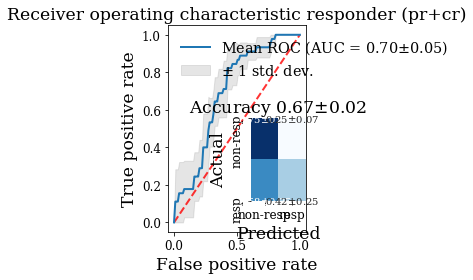

In [14]:
from views import plot_roc_curve
plt.rc("font", family="serif")
# plt.figure(figsize=(4, 3))
plot_roc_curve(resp_mean, resp_std, class_name='responder (pr+cr)', labels=['non-resp', 'resp'])
plt.savefig('response_prediction.png')

## Predicting overall survival

Accuracy: 0.6556302521008404


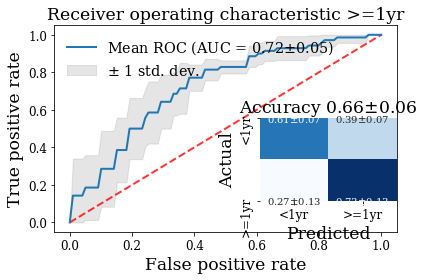

In [11]:
plot_roc_curve(OS_mean, OS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('os_prediction.png')

## Predicting progression free survival

Accuracy: 0.6947899159663866


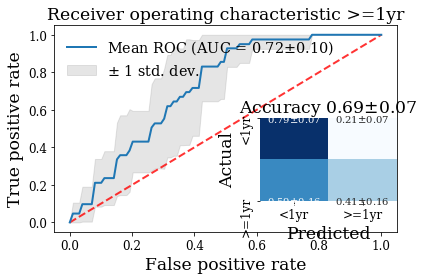

In [12]:
plot_roc_curve(PFS_mean, PFS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('pfs_prediction.png')

# Predicting responders, non-responders _and_ non-evaluable.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


non responder (sd+pd) 0.6956521739130435
responder (pr+cr) 0.6495726495726496
non evaluable (ne) 0.9270833333333334
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


non responder (sd+pd) 0.7572463768115942
responder (pr+cr) 0.7905982905982906
non evaluable (ne) 0.7708333333333333
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


non responder (sd+pd) 0.6485507246376812
responder (pr+cr) 0.7307692307692308
non evaluable (ne) 0.6354166666666666
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


non responder (sd+pd) 0.5978260869565217
responder (pr+cr) 0.6666666666666667
non evaluable (ne) 0.46875
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


non responder (sd+pd) 0.6212121212121212
responder (pr+cr) 0.7066666666666667
non evaluable (ne) 0.4516129032258064
Accuracy: 0.6547899159663866
Accuracy: 0.7005042016806724
Accuracy: 0.8504201680672269


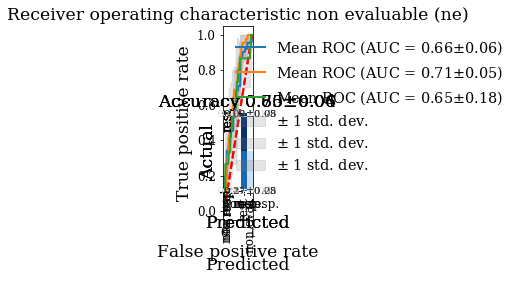

In [13]:
p.fit(X, y['response_grouped'])
m_mean, m_std = multi_class_metrics(p, X, y['response_grouped'])
for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
    plot_roc_curve(m_mean, m_std, class_name)